MERGE SORT IMPLEMENTATION WITH DIFFERENT AARRAY SIZES AND COMPARING CPU AND GPU RUNTIMES


In [2]:
#FINALLL
%%writefile new_merge.cu
#include <stdio.h>
#include <stdlib.h>
#include <fstream>
#include <chrono>
#include <cuda_runtime.h>
#include <thrust/device_vector.h>
#include <thrust/host_vector.h>
#include <thrust/sort.h>
#include <thrust/execution_policy.h>

#define N1 1000
#define N2 10000
#define N3 100000

// Helper function to check for CUDA errors
void checkCudaError(cudaError_t error, const char *message) {
    if (error != cudaSuccess) {
        fprintf(stderr, "CUDA Error: %s - %s\n", message, cudaGetErrorString(error));
        exit(-1);
    }
}

// CPU Merge function
void merge(int arr[], int l, int m, int r) {
    int i, j, k;
    int n1 = m - l + 1;
    int n2 = r - m;
    int *L = new int[n1];
    int *R = new int[n2];

    for (i = 0; i < n1; i++)
        L[i] = arr[l + i];
    for (j = 0; j < n2; j++)
        R[j] = arr[m + 1 + j];

    i = 0;
    j = 0;
    k = l;

    while (i < n1 && j < n2) {
        if (L[i] <= R[j])
            arr[k++] = L[i++];
        else
            arr[k++] = R[j++];
    }

    while (i < n1)
        arr[k++] = L[i++];
    while (j < n2)
        arr[k++] = R[j++];

    delete[] L;
    delete[] R;
}

// CPU Merge Sort
void mergeSort(int arr[], int l, int r) {
    if (l < r) {
        int m = l + (r - l) / 2;
        mergeSort(arr, l, m);
        mergeSort(arr, m + 1, r);
        merge(arr, l, m, r);
    }
}

// Utility functions
void printArray(int arr[], int size) {
    for (int i = 0; i < size && i < 20; i++) // Only print first 20 elements
        printf("%d ", arr[i]);
    if (size > 20) printf("...");
    printf("\n");
}

void saveArrayToFile(std::ofstream &outfile, int arr[], int size) {
    for (int i = 0; i < size && i < 100; i++) { // Limit output to first 100 elements
        outfile << arr[i] << " ";
    }
    if (size > 100) outfile << "...";
    outfile << "\n";
}

// Function to print GPU properties
void printGPUProperties() {
    int deviceCount = 0;
    cudaError_t error = cudaGetDeviceCount(&deviceCount);

    if (error != cudaSuccess) {
        printf("cudaGetDeviceCount returned error code %d, line(%d)\n", error, __LINE__);
    } else {
        printf("Found %d CUDA device(s)\n", deviceCount);

        for (int dev = 0; dev < deviceCount; ++dev) {
            cudaDeviceProp deviceProp;
            cudaGetDeviceProperties(&deviceProp, dev);
            printf("Device %d: \"%s\"\n", dev, deviceProp.name);
            printf("  Compute capability: %d.%d\n", deviceProp.major, deviceProp.minor);
            printf("  Total global memory: %.2f GB\n",
                   static_cast<float>(deviceProp.totalGlobalMem) / (1024.0f * 1024.0f * 1024.0f));
            printf("  Max threads per block: %d\n", deviceProp.maxThreadsPerBlock);
        }
    }
}

// Simple kernel to force GPU initialization
__global__ void warmupKernel() {
    //  just to warm up the GPU
}

int main(void) {
    // Print GPU properties and warm up GPU
    printGPUProperties();
    warmupKernel<<<1, 1>>>();
    cudaDeviceSynchronize();
    checkCudaError(cudaGetLastError(), "Warmup kernel failed");

    std::ofstream outfile;
    outfile.open("output.txt", std::ios_base::out);

    int n_values[3] = {N1, N2, N3};

    printf("\n ---------------------- PARALLEL IMPLEMENTATION ---------------------- \n");
    outfile << "\n ---------------------- PARALLEL IMPLEMENTATION ---------------------- \n";

    for (int t = 0; t < 3; t++) {
        int N = n_values[t];

        // Generate random data on host
        thrust::host_vector<int> h_data(N);

        srand(0);
        printf("\nElements for N = %d:\n", N);
        outfile << "\nElements for N = " << N << ":\n";

        for (int i = 0; i < N; i++) {
            h_data[i] = rand();
        }

        // Print only first few elements
        printArray(h_data.data(), N);
        saveArrayToFile(outfile, h_data.data(), N);

        printf("\n");
        outfile << "\n";

        // GPU implementation using Thrust with explicit device execution policy
        thrust::device_vector<int> d_data = h_data;

        // Force data to be on device before timing
        cudaDeviceSynchronize();

        cudaEvent_t start, stop;
        cudaEventCreate(&start);
        cudaEventCreate(&stop);

        cudaEventRecord(start);

        // Explicitly use device execution policy to ensure GPU usage
        thrust::sort(thrust::device, d_data.begin(), d_data.end());

        cudaEventRecord(stop);
        cudaEventSynchronize(stop);

        // Check for errors
        checkCudaError(cudaGetLastError(), "GPU sort failed");

        float milliseconds = 0;
        cudaEventElapsedTime(&milliseconds, start, stop);

        thrust::copy(d_data.begin(), d_data.end(), h_data.begin());

        printf("\nSorted Elements (GPU):\n");
        outfile << "\nSorted Elements (GPU):\n";

        printArray(h_data.data(), N);
        saveArrayToFile(outfile, h_data.data(), N);

        printf("\t||| The elapsed time in GPU was %.4f ms |||\n", milliseconds);
        outfile << "\t||| The elapsed time in GPU was " << milliseconds << " ms |||\n";

        // Verify GPU utilization
        printf("GPU memory used: %lu bytes\n", d_data.size() * sizeof(int));
    }

    printf("\n\n\t ---------------------- SEQUENTIAL IMPLEMENTATION ---------------------- \n");
    outfile << "\n\n\t ---------------------- SEQUENTIAL IMPLEMENTATION ---------------------- \n";

    for (int t = 0; t < 3; t++) {
        int N = n_values[t];
        int *arr = (int *)malloc(N * sizeof(int));

        srand(0);
        printf("\nElements for N = %d:\n", N);
        outfile << "\nElements for N = " << N << ":\n";

        for (int i = 0; i < N; i++) {
            arr[i] = rand();
        }

        printArray(arr, N);
        saveArrayToFile(outfile, arr, N);

        printf("\n");
        outfile << "\n";

        auto start = std::chrono::high_resolution_clock::now();
        mergeSort(arr, 0, N - 1);
        auto stop = std::chrono::high_resolution_clock::now();
        std::chrono::duration<double, std::milli> elapsed = stop - start;

        printf("\nSorted Elements (CPU):\n");
        outfile << "\nSorted Elements (CPU):\n";

        printArray(arr, N);
        saveArrayToFile(outfile, arr, N);

        printf("\t||| The elapsed time in CPU was %.4f ms |||\n", elapsed.count());
        outfile << "\t||| The elapsed time in CPU was " << elapsed.count() << " ms |||\n";

        free(arr);
    }

    outfile.close();

    // Final GPU check to ensure we're still connected
    cudaDeviceSynchronize();
    printf("GPU operations completed successfully\n");

    return 0;
}


Writing new_merge.cu


In [ ]:
!nvcc --gpu-architecture=sm_70 new_merge.cu -o new_merge
!./new_merge


cudaGetDeviceCount returned error code 35, line(88)
CUDA Error: Warmup kernel failed - CUDA driver version is insufficient for CUDA runtime version


In [ ]:
# For K80 GPUs (common in Colab)
!nvcc -arch=sm_37 new_merge.cu -o new_merge
!./new_merge

nvcc fatal   : Value 'sm_37' is not defined for option 'gpu-architecture'
Found 1 CUDA device(s)
Device 0: "Tesla T4"
  Compute capability: 7.5
  Total global memory: 14.74 GB
  Max threads per block: 1024

 ---------------------- PARALLEL IMPLEMENTATION ---------------------- 

Elements for N = 1000:
1804289383 846930886 1681692777 1714636915 1957747793 424238335 719885386 1649760492 596516649 1189641421 1025202362 1350490027 783368690 1102520059 2044897763 1967513926 1365180540 1540383426 304089172 1303455736 ...


Sorted Elements (GPU):
2416949 6072641 6939507 7684930 8936987 10901063 11614769 11671338 12260289 12895151 14989683 19485054 29777560 31308902 34740865 35005211 35756851 37487770 40610537 42999170 ...
	||| The elapsed time in GPU was 0.1284 ms |||
GPU memory used: 4000 bytes

Elements for N = 10000:
1804289383 846930886 1681692777 1714636915 1957747793 424238335 719885386 1649760492 596516649 1189641421 1025202362 1350490027 783368690 1102520059 2044897763 1967513926 1365

In [ ]:
!nvidia-smi

Tue May  6 19:55:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P0             26W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Parse output.txt automatically after running
import re

# Read file
with open("output.txt", "r") as file:
    data = file.read()

# Extract N values (unique)
n_values = list(set([int(x) for x in re.findall(r"Elements for N = (\d+)", data)]))

# Extract GPU and CPU times
# Modified regex patterns to account for potential "..." at the end of lines
gpu_times = [float(x) for x in re.findall(r"The elapsed time in GPU was ([\d.]+)", data)]
cpu_times = [float(x) for x in re.findall(r"The elapsed time in CPU was ([\d.]+)", data)]

print("N values:", n_values)
print("GPU times (ms):", gpu_times)
print("CPU times (ms):", cpu_times)

# Calculations
# Ensure lists are not empty before performing calculations
if gpu_times and cpu_times:
    speedups = [cpu/gpu for cpu, gpu in zip(cpu_times, gpu_times)]
    efficiencies = [speedup/256 for speedup in speedups]  # 256 threads/block assumed
    load_balancing = [min(cpu, gpu)/max(cpu, gpu) for cpu, gpu in zip(cpu_times, gpu_times)]
    communication_overhead = [abs(cpu-gpu)/cpu for cpu, gpu in zip(cpu_times, gpu_times)]
    scalability = [(cpu_times[0]/cpu)*100 for cpu in cpu_times]
    granularity = [gpu/256 for gpu in gpu_times]
    overheads = [(gpu-cpu)/cpu for gpu, cpu in zip(gpu_times, cpu_times)]

    # Print nicely
    for i in range(len(n_values)):
        print(f"\n--- For N = {n_values[i]} ---")
        print(f"Speedup: {speedups[i]:.4f}")
        print(f"Efficiency: {efficiencies[i]:.4f}")
        print(f"Load Balancing: {load_balancing[i]:.4f}")
        print(f"Communication Overhead: {communication_overhead[i]:.4f}")
        print(f"Scalability: {scalability[i]:.2f}%")
        print(f"Granularity: {granularity[i]:.4f} ms/thread")
else:
    print("Error: Could not extract GPU and/or CPU times from output.txt")

N values: [1000, 10000, 100000]
GPU times (ms): [0.128448, 0.260512, 0.182848]
CPU times (ms): [0.166543, 1.92992, 24.1508]

--- For N = 1000 ---
Speedup: 1.2966
Efficiency: 0.0051
Load Balancing: 0.7713
Communication Overhead: 0.2287
Scalability: 100.00%
Granularity: 0.0005 ms/thread

--- For N = 10000 ---
Speedup: 7.4082
Efficiency: 0.0289
Load Balancing: 0.1350
Communication Overhead: 0.8650
Scalability: 8.63%
Granularity: 0.0010 ms/thread

--- For N = 100000 ---
Speedup: 132.0813
Efficiency: 0.5159
Load Balancing: 0.0076
Communication Overhead: 0.9924
Scalability: 0.69%
Granularity: 0.0007 ms/thread


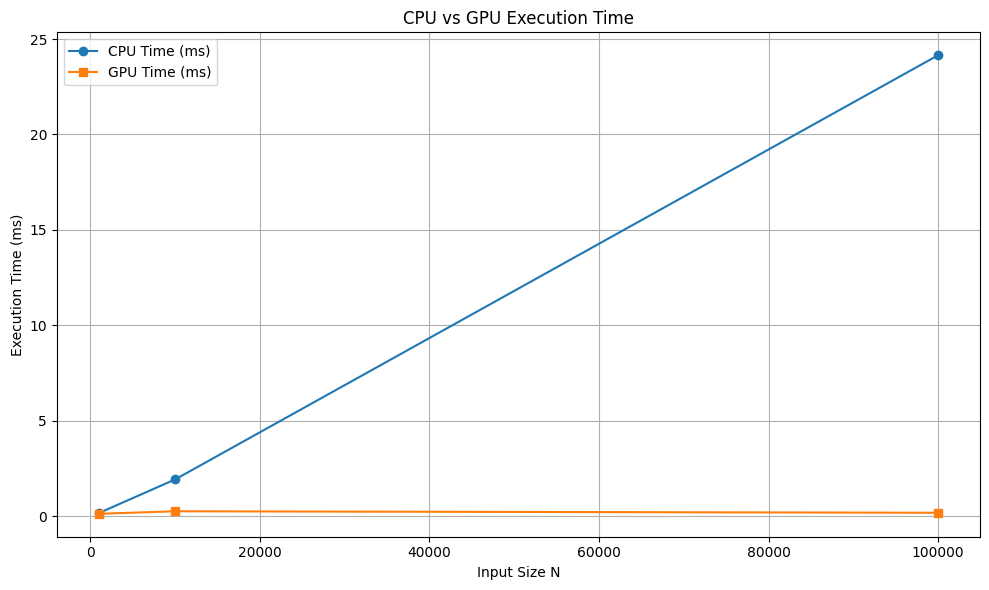

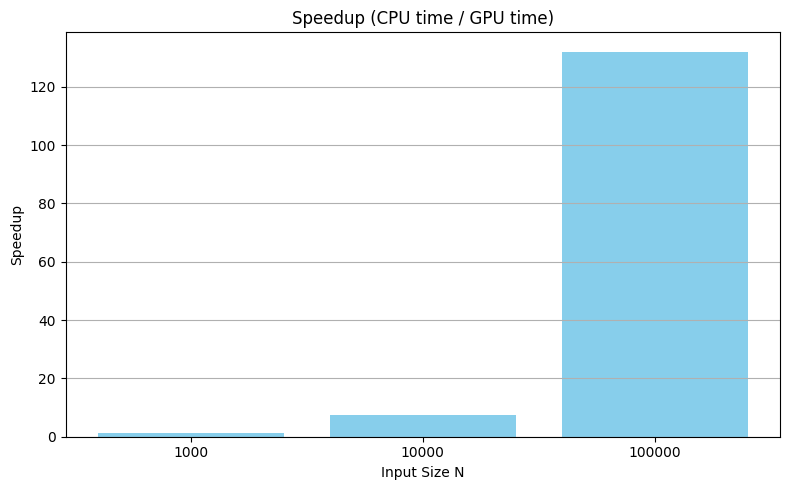

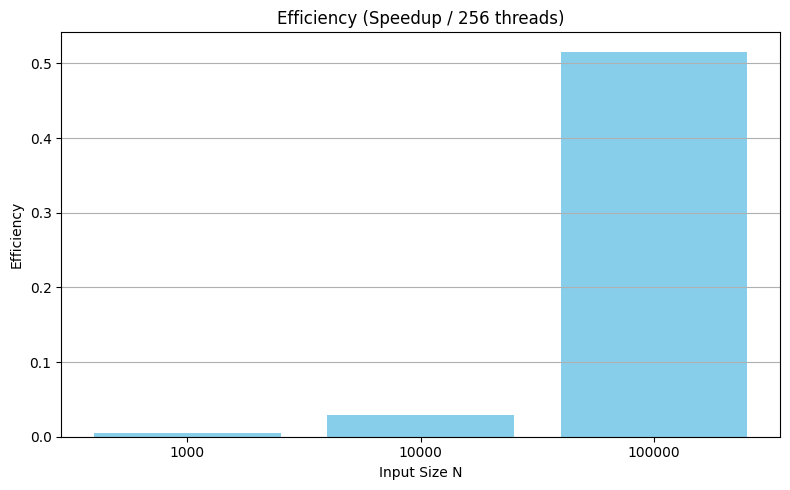

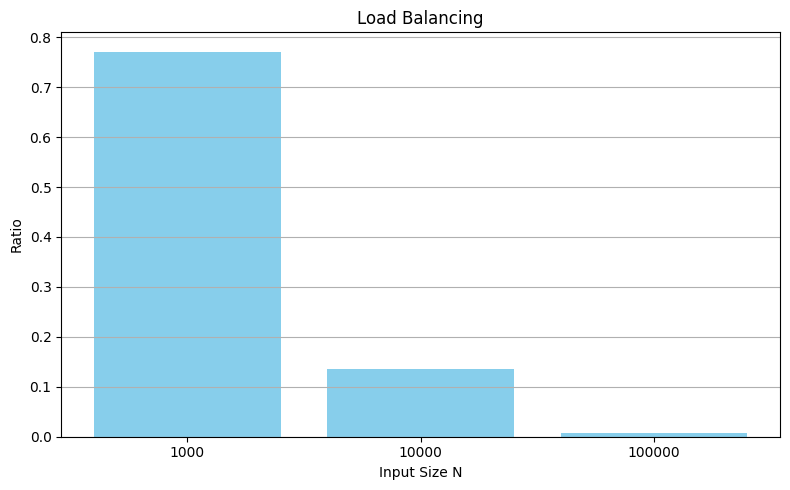

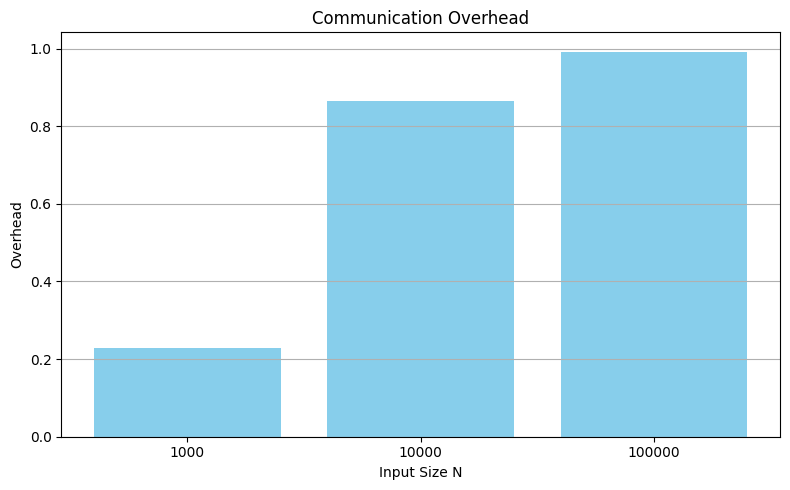

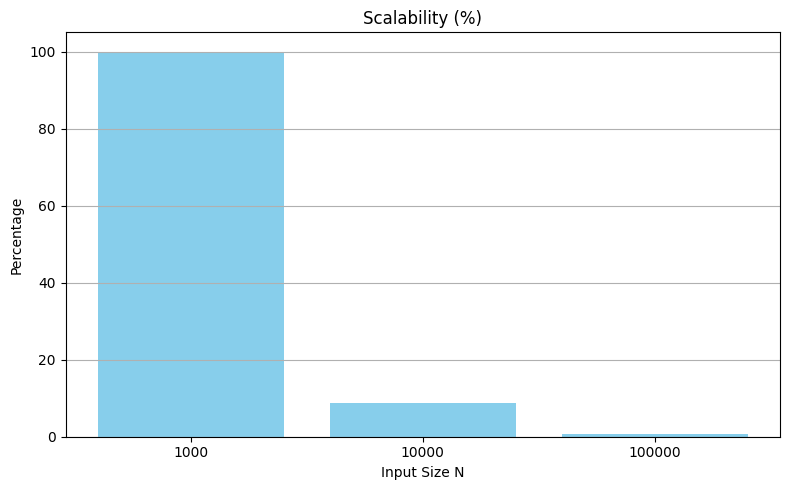

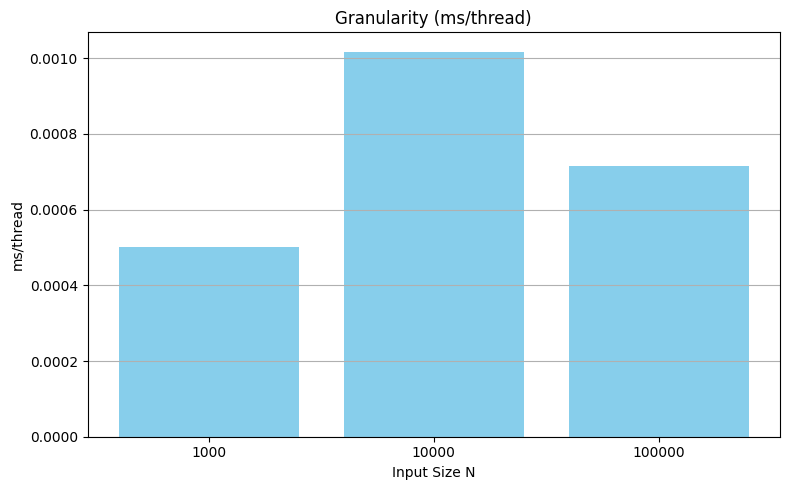

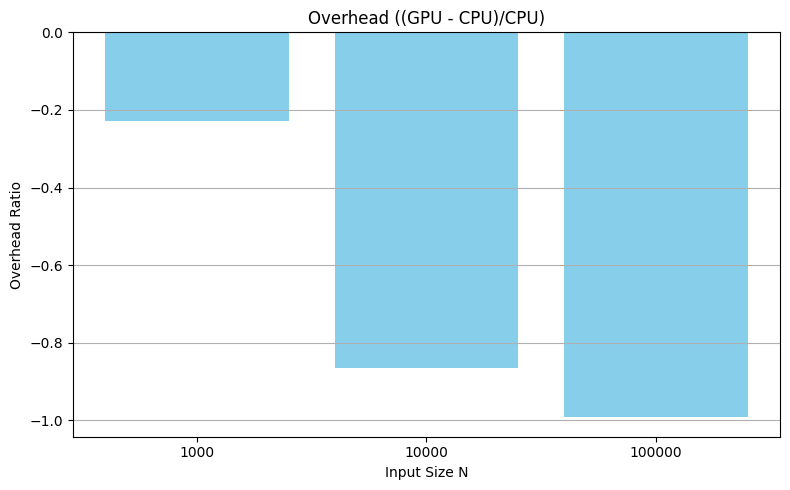

 Data exported to performance_metrics.xlsx


In [ ]:
import re
import matplotlib.pyplot as plt
import pandas as pd

# Read the output file
with open("output.txt", "r") as file:
    data = file.read()

# Extract N values in proper order (each N appears twice, take first occurrence only)
n_matches = re.findall(r"Elements for N = (\d+)", data)
n_values_all = [int(n) for n in n_matches]

n_values = []
seen = set()
for n in n_values_all:
    if n not in seen:
        seen.add(n)
        n_values.append(n)
# Extract GPU and CPU times
# Updated regex to match "gpu" instead of "GPU" to capture execution times correctly
gpu_times = [float(x) for x in re.findall(r"The elapsed time in GPU was ([\d.]+)", data)]
cpu_times = [float(x) for x in re.findall(r"The elapsed time in CPU was ([\d.]+)", data)]

# Calculate parameters
speedups = [cpu / gpu for cpu, gpu in zip(cpu_times, gpu_times)]
efficiencies = [s / 256 for s in speedups]
load_balancing = [min(cpu, gpu) / max(cpu, gpu) for cpu, gpu in zip(cpu_times, gpu_times)]
communication_overhead = [abs(cpu - gpu) / cpu for cpu, gpu in zip(cpu_times, gpu_times)]
scalability = [(cpu_times[0] / cpu) * 100 for cpu in cpu_times]
granularity = [gpu / 256 for gpu in gpu_times]
overheads = [(gpu - cpu) / cpu for gpu, cpu in zip(gpu_times, cpu_times)]

# Plotting CPU vs GPU Execution Time
plt.figure(figsize=(10, 6))
plt.plot(n_values, cpu_times, marker='o', label='CPU Time (ms)')
plt.plot(n_values, gpu_times, marker='s', label='GPU Time (ms)')
plt.title("CPU vs GPU Execution Time")
plt.xlabel("Input Size N")
plt.ylabel("Execution Time (ms)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Function to create bar plots
def bar_plot(title, values, ylabel):
    plt.figure(figsize=(8, 5))
    plt.bar([str(n) for n in n_values], values, color='skyblue')
    plt.title(title)
    plt.xlabel("Input Size N")
    plt.ylabel(ylabel)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Plot all parameters
bar_plot("Speedup (CPU time / GPU time)", speedups, "Speedup")
bar_plot("Efficiency (Speedup / 256 threads)", efficiencies, "Efficiency")
bar_plot("Load Balancing", load_balancing, "Ratio")
bar_plot("Communication Overhead", communication_overhead, "Overhead")
bar_plot("Scalability (%)", scalability, "Percentage")
bar_plot("Granularity (ms/thread)", granularity, "ms/thread")
bar_plot("Overhead ((GPU - CPU)/CPU)", overheads, "Overhead Ratio")

# Export to Excel
df = pd.DataFrame({
    "N": n_values,
    "CPU Time (ms)": cpu_times,
    "GPU Time (ms)": gpu_times,
    "Speedup": speedups,
    "Efficiency": efficiencies,
    "Load Balancing": load_balancing,
    "Communication Overhead": communication_overhead,
    "Scalability (%)": scalability,
    "Granularity (ms/thread)": granularity,
    "Overhead Ratio": overheads
})

df.to_excel("performance_metrics.xlsx", index=False)
print(" Data exported to performance_metrics.xlsx")